## This analysis Goes through the exercises from Lecture 03:
Feel free to run the notebook in Google Colab

In [1]:
# ========================================== 
# Set Global Variables:
# ========================================== 
# set system
import sys
IN_COLAB = 'google.colab' in sys.modules
ABDUL_G_DRIVE = False   # When set to True it will reads from Abdul's G-Drive. Not accessable! 

# set torch device
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set seed (if not defined will be used as default)
_SEED_ = 123456

In [2]:
# ========================================== 
# Initlize Colab:
# ========================================== 
# connect to drive
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')

  # set project path from drive
  if ABDUL_G_DRIVE:
    project_path = "/content/gdrive/MyDrive/00 Projects/AML"
    %cd -q $project_path 
    !pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/00 Projects/AML


In [3]:
# ========================================== 
# Install 
# ========================================== 
# define dynamic function to install pyg
def install_pyg():
    try:
        import torch_geometric
    except:
        TORCH = torch.__version__.split('+')[0]
        CUDA = 'cu' + torch.version.cuda.replace('.', '')
        !pip install torch-scatter     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-sparse      -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-cluster     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-spline-conv -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-geometric   -q

# install
if IN_COLAB: install_pyg()

In [4]:
# ========================================== 
# Load Dependencies
# ========================================== 
# src 
from models import MLP, GCN, GAT
from random_split import random_split
from p_reg_loss import A_hat_computations, p_reg_loss
from lap_loss import lap_loss
from helper import visualize_Atlas, visualize_TSNE, visualize_CM, print_dataset, print_data

# packages
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time

In [5]:
# ==========================================
# Train and Evaluation functions 
# ==========================================
# Train function
def train(model, optimizer, criterion, data, train_mask, mu, reg_loss, p_reg_dict=None):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    _, Z = model(data)     # Perform a single forward pass.    
    loss_1 = criterion(Z[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
    if reg_loss == 'p_reg':
      loss_2 = p_reg_loss(Z, 
                          p_reg_dict['A_hat'], 
                          p_reg_dict['A_hat_mask'], 
                          p_reg_dict['N'], 
                          phi = p_reg_dict['phi'])
    elif reg_loss == 'lap_reg': 
      loss_2 = lap_loss(Z, data) 
    elif reg_loss == 'no_reg':
      loss_2 = 0
      assert mu == 0
    loss = loss_1 + mu * loss_2      
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, Z

# Evaluation
def test(model, data, mask):
    model.eval()
    _, Z = model(data)
    y_pred = Z.argmax(dim=1)  # Use the class with highest probability.
    score = torch.softmax(Z, dim=1)
    acc = accuracy_score    (y_true = data.y[mask].cpu().detach().numpy(), y_pred  = y_pred[mask].cpu().detach().numpy())
    rms = mean_squared_error(y_true = data.y[mask].cpu().detach().numpy(), y_pred  = y_pred[mask].cpu().detach().numpy(), squared=False)
    roc = roc_auc_score     (y_true = data.y[mask].cpu().detach().numpy(), y_score = score [mask, :].cpu().detach().numpy(), multi_class='ovr')
    return acc, rms, roc, y_pred

In [6]:
# ==========================================
# Main: Train Evaluation Loop function
# ==========================================
def train_evaluation(A = None,
                     As = None, 
                     B = None,
                     Bs = None,   # 180 is the max for sum A and B 
                     seed = 123456,
                     seeds = None,
                     mu = 0,
                     mus = None,
                     phi = 'cross_entropy',
                     epochs = 201,
                     datasets = ['Cora', 'CiteSeer', 'PubMed'],
                     show = True,
                     reg_loss = None):
    
    # check regulization loss
    if (mu != 0) or (mus is not None):
        assert reg_loss in ['p_reg', 'lap_reg'], "reg_loss must be from ['p_reg', 'lap_reg']"
    else: reg_loss= 'no_reg'

    # define loop parameter
    if mus is not None:
        params, params_len, params_tag = mus, len(mus),'mu'
        assert mu == 0, "mu and mus are given in the same time"
        if show: print(f'Training with different "Mus" (with {reg_loss}):')
    elif seeds is not None:
        params, params_len, params_tag = seeds, len(seeds),'seed'
        if show: print(f'Training with different "Seeds" (with {reg_loss}):')
    elif As is not None: 
        params, params_len, params_tag = As, len(As),'No. Training Nodes'
        assert A is None, "A and As are given in the same time"
        assert B is None, "B and Bs are given in the same time"
        if show: print(f'Training with different "Number Training Nodes" (with {reg_loss}):')
    else:
        raise NotImplemented('The input Combination is not supported')

    # evaluation Storage
    Results = {}
    
    # loop over datasets
    for dataset_name in datasets: 
        # define dataset
        if show: print(f'=========================\n{dataset_name}:')
        if dataset_name == 'Cora':
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='Cora', transform=NormalizeFeatures())
            else: dataset = Planetoid(root=f'/tmp/Cora', name='Cora', transform=NormalizeFeatures())
        elif dataset_name == 'CiteSeer':
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
            else: dataset = Planetoid(root=f'/tmp/CiteSeer', name='CiteSeer', transform=NormalizeFeatures())
        elif dataset_name == 'PubMed':
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='PubMed', transform=NormalizeFeatures())         
            else: dataset = Planetoid(root=f'/tmp/PubMed', name='PubMed', transform=NormalizeFeatures())         
        else:
            raise NotImplementedError('Only Cora, CiteSeer and PubMed datasets are supported')
        
        # define data
        data = dataset[0]
        data = data.to(device)
        
        # Calculate A_hat as it's training invariant 
        if reg_loss == 'p_reg':
            A_hat, A_hat_mask, N = A_hat_computations(data)

        # define dataset evaluation metrices
        Results[dataset_name+'_acc']  = [],[]   # val, test
        Results[dataset_name+'_rms']  = [],[]
        Results[dataset_name+'_roc']  = [],[]
        Results[dataset_name+'_loss'] = []      # train

        # loop over params
        for i in range(params_len):
            # define model parameters        
            if params_tag == 'mu': 
                mu = mus[i]
            elif params_tag == 'seed': 
                seed = seeds[i]
            elif params_tag == 'No. Training Nodes': 
                A, B = As[i], Bs[i]

            # calc the split
            if (A is not None) & (B is not None):
                train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
            else:
                train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask

            # define MOC
            model = GCN(dataset, hidden_channels=16, seed = seed).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()

            # define epoch evaluation metrices
            val_acc_lst , val_rms_lst , val_roc_lst  = [], [], []
            test_acc_lst, test_rms_lst, test_roc_lst = [], [], []
            loss_lst = []

            # loop over epochs
            # Z = None # can be used for visulizing the embaddings 
            for epoch in range(epochs):
                # train
                if reg_loss == 'p_reg':  
                    p_reg_dict = {'A_hat':A_hat, 'A_hat_mask':A_hat_mask, 'N':N, 'phi':phi}
                    loss, _ = train(model, optimizer, criterion, data, train_mask, mu, reg_loss, p_reg_dict)
                else: # handels both no_reg and lap_reg cases 
                    loss, _ = train(model, optimizer, criterion, data, train_mask, mu, reg_loss)

                # evaluate 
                with torch.no_grad():
                  val_acc , val_rms , val_roc , _ = test(model, data, data.val_mask)
                  test_acc, test_rms, test_roc, _ = test(model, data, data.test_mask)

                  # save metrices 
                  val_acc_lst .append(val_acc) 
                  val_rms_lst .append(val_rms) 
                  val_roc_lst .append(val_roc) 
                  test_acc_lst.append(test_acc) 
                  test_rms_lst.append(test_rms) 
                  test_roc_lst.append(test_roc)
                  loss_lst.append(float(loss))

            # save means metrices for val
            Results[dataset_name+'_acc'][0].append(np.mean(val_acc_lst))
            Results[dataset_name+'_rms'][0].append(np.mean(val_rms_lst))
            Results[dataset_name+'_roc'][0].append(np.mean(val_roc_lst))
            # save means metrices for test
            Results[dataset_name+'_acc'][1].append(np.mean(test_acc_lst))
            Results[dataset_name+'_rms'][1].append(np.mean(test_rms_lst))
            Results[dataset_name+'_roc'][1].append(np.mean(test_roc_lst))
            # save means loss for train
            Results[dataset_name+'_loss'].append(np.mean(loss_lst))
            
            # Print 
            condition = ((show) & (i % 2 == 0)) if (len(params) < 10) else ((show) & (i % 5 == 0))
            precent = int(i/len(params)*100)
            if condition:
                if params_tag == 'No. Training Nodes': 
                    print(f'{precent}%: A,B= ({A},{B}), Loss: {np.mean(loss_lst):.4f}')            
                elif params_tag == 'seed': 
                    print(f'{precent}%: seed= {seed}, Loss: {np.mean(loss_lst):.4f}')            
                elif params_tag == 'mu': 
                    print(f'{precent}%: mu= {mu:.4f}, Loss: {np.mean(loss_lst):.4f}')
                print(f'    Val_acc : {np.mean(val_acc_lst):.4f}, Val_rms : {np.mean(val_rms_lst):.4f}, Val_roc : {np.mean(val_roc_lst):.4f}')
                print(f'    Test_acc: {np.mean(test_acc_lst):.4f}, Test_rms: {np.mean(test_rms_lst):.4f}, Test_roc: {np.mean(test_roc_lst):.4f}')

    return Results, params, params_tag, reg_loss

In [7]:
# ==========================================
# Report functions
# ==========================================

# viz report:  metrices vs params for the 3 datasets on test
def report_vis(Results, params, params_tag, reg_loss):
    # Auxiliary function for ordring list w.r.t another list
    def aux_sort(lst,params):
          return [i for _,i in sorted(zip(params,lst))]
    # Set figure params
    datasets  = ['Cora', 'CiteSeer', 'PubMed']
    colors    = ['green', 'blue', 'red']
    tags      = ['acc', 'rms', 'roc']
    titles    = ['Accuracy', 'RMS', 'ROC-AUC']
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle(f"{params_tag.capitalize()} Vs. Evaluation Metrics",fontsize=18)
    for i_tag,tag in enumerate(tags):    
        for i_data,dataset_name in enumerate(datasets):
          axs[i_tag].plot(sorted(params),aux_sort(Results[f'{dataset_name}_{tag}'][1],params), color=colors[i_data], marker='o', label=f'{dataset_name}')
          axs[i_tag].legend()
          axs[i_tag].set_title(f'{titles[i_tag]}')
          axs[i_tag].set_xlabel(params_tag)
          axs[i_tag].set_xticks(sorted(params))
          axs[i_tag].set_xticklabels(sorted(np.round(params,3) if (type(params)==np.ndarray) else params), rotation='vertical')
          axs[i_tag].set_ylabel(f'{tags[i_tag]}')
          axs[i_tag].grid(True)
    
    caption =  f"The figure shows: {params_tag.capitalize()} Vs. Accuracy, RMS and ROC-AUC for the 3 datasets.\n"+\
                "The model is evaluated with "+ reg_loss +" on test data." 
    plt.figtext(0.5, -0.2, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

# stats report: best params for the 3 datasets on test
def report_stats(Results, params, params_tag):
    # Set stats params
    datasets  = ['Cora', 'CiteSeer', 'PubMed']
    tags      = ['acc', 'rms', 'roc']
    titles    = ['Accuracy', 'RMS', 'ROC-AUC']
    for dataset_name in datasets:
        print(f'========= {dataset_name}:')
        for tag in tags:
            if tag != 'rms':
                best = params[np.argmax(Results[f'{dataset_name}_{tag}'][1])]
                best = np.round(best, 3) if ((type(best) == np.float64) or (type(best) == float)) else best
                print(f"    {tag} best {params_tag} on test: {best}")
            else:
                best = params[np.argmin(Results[f'{dataset_name}_{tag}'][1])]
                best = np.round(best, 3) if ((type(best) == np.float64) or (type(best) == float)) else best
                print(f"    {tag} best {params_tag} on test: {best}")

In [ ]:
# A = None
# As = None 
# B = None
# Bs = None   # 180 is the max for sum A and B 
# seed = 123456
# seeds = None
# mu = 0
# mus = None
# phi = 'cross_entropy'
# epochs = 201
# datasets = ['Cora', 'CiteSeer', 'PubMed']
# show = True
# reg_loss = None

In [8]:
# ============================================ 
# L03 P02 Q01 with P-reg
# ============================================
# set parameters
phi = 'cross_entropy'
mus = np.linspace(0,1,20)

In [9]:
# train and evaluate 
Results, params, params_tag, reg_loss = train_evaluation(mus=mus, phi = 'cross_entropy', reg_loss='p_reg')

Training with different "Mus" (with p_reg):
Cora:
0%: mu= 0.0000, Loss: 0.8250
    Val_acc : 0.7575, Val_rms : 1.5691, Val_roc : 0.9382
    Test_acc: 0.7724, Test_rms: 1.4228, Test_roc: 0.9483
25%: mu= 0.2632, Loss: 1.2184
    Val_acc : 0.7766, Val_rms : 1.5048, Val_roc : 0.9409
    Test_acc: 0.7829, Test_rms: 1.3977, Test_roc: 0.9504
50%: mu= 0.5263, Loss: 1.5796
    Val_acc : 0.7745, Val_rms : 1.4578, Val_roc : 0.9428
    Test_acc: 0.7810, Test_rms: 1.3882, Test_roc: 0.9514
75%: mu= 0.7895, Loss: 1.9309
    Val_acc : 0.7048, Val_rms : 1.7939, Val_roc : 0.9401
    Test_acc: 0.7165, Test_rms: 1.7150, Test_roc: 0.9487
CiteSeer:
0%: mu= 0.0000, Loss: 0.8093
    Val_acc : 0.6801, Val_rms : 1.2254, Val_roc : 0.8928
    Test_acc: 0.6792, Test_rms: 1.4231, Test_roc: 0.8872
25%: mu= 0.2632, Loss: 1.1898
    Val_acc : 0.6865, Val_rms : 1.2165, Val_roc : 0.8985
    Test_acc: 0.6874, Test_rms: 1.3861, Test_roc: 0.8928
50%: mu= 0.5263, Loss: 1.5361
    Val_acc : 0.6942, Val_rms : 1.1777, Val_roc 

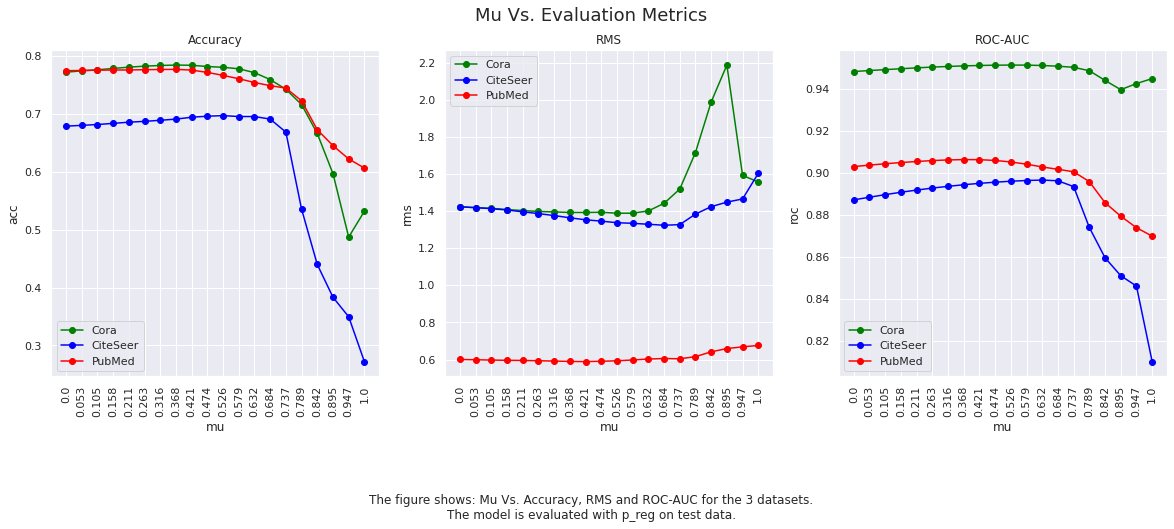

In [10]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [11]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best mu on test: 0.368
    rms best mu on test: 0.526
    roc best mu on test: 0.526
========= CiteSeer:
    acc best mu on test: 0.526
    rms best mu on test: 0.684
    roc best mu on test: 0.632
========= PubMed:
    acc best mu on test: 0.368
    rms best mu on test: 0.421
    roc best mu on test: 0.368


In [12]:
# ============================================ 
# L03 P02 Q02 (without P-reg)
# ===========================================
# set parameters
A        = 20
B        = 30
seeds    = np.random.randint(0, high=1000, size=10, dtype=int)

In [13]:
# train and evaluate 
Results, params, params_tag, reg_loss = train_evaluation(A = A, B = B, seeds = seeds, reg_loss=None)

Training with different "Seeds" (with no_reg):
Cora:
0%: seed= 4, Loss: 0.7465
    Val_acc : 0.3499, Val_rms : 2.5982, Val_roc : 0.7988
    Test_acc: 0.3782, Test_rms: 2.5209, Test_roc: 0.7971
50%: seed= 297, Loss: 0.5607
    Val_acc : 0.3479, Val_rms : 2.7357, Val_roc : 0.8209
    Test_acc: 0.3460, Test_rms: 2.6767, Test_roc: 0.8385
CiteSeer:
0%: seed= 4, Loss: 0.6525
    Val_acc : 0.2950, Val_rms : 1.5894, Val_roc : 0.7280
    Test_acc: 0.2385, Test_rms: 1.6782, Test_roc: 0.7361
50%: seed= 297, Loss: 0.6492
    Val_acc : 0.2366, Val_rms : 1.8666, Val_roc : 0.7044
    Test_acc: 0.2165, Test_rms: 1.9089, Test_roc: 0.7383
PubMed:
0%: seed= 4, Loss: 0.2537
    Val_acc : 0.5502, Val_rms : 0.7984, Val_roc : 0.8185
    Test_acc: 0.5189, Test_rms: 0.8238, Test_roc: 0.8166
50%: seed= 297, Loss: 0.3460
    Val_acc : 0.6556, Val_rms : 0.6347, Val_roc : 0.8575
    Test_acc: 0.6600, Test_rms: 0.6445, Test_roc: 0.8443


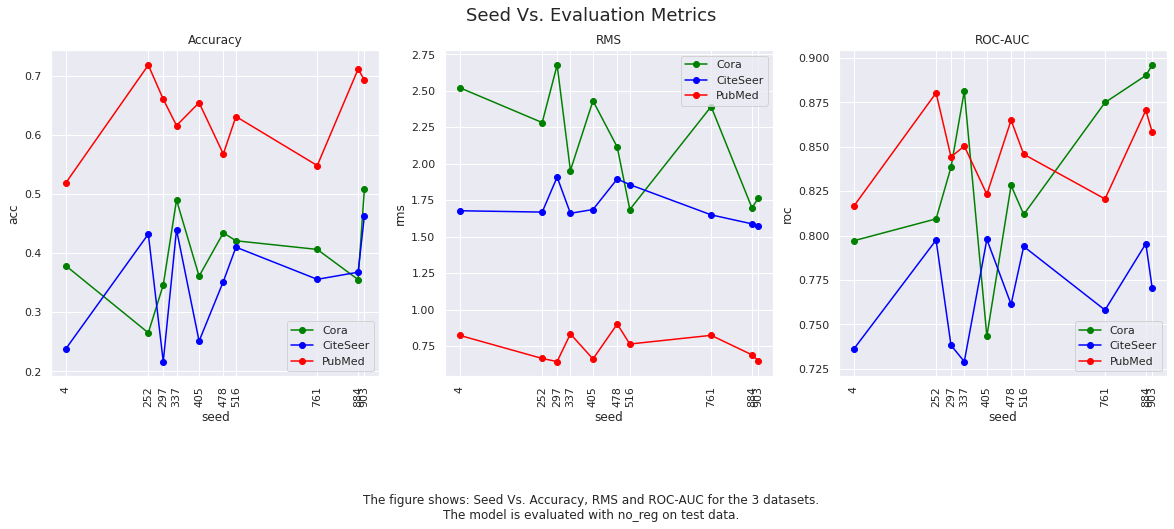

In [14]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [15]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best seed on test: 903
    rms best seed on test: 516
    roc best seed on test: 903
========= CiteSeer:
    acc best seed on test: 903
    rms best seed on test: 903
    roc best seed on test: 405
========= PubMed:
    acc best seed on test: 252
    rms best seed on test: 297
    roc best seed on test: 252


In [16]:
# ============================================ 
# L03 P02 Q02 (with P-reg)
# ===========================================
# set parameters
A        = 20
B        = 30
mu       = 0.3
seeds    = np.random.randint(0, high=1000, size=10, dtype=int)

In [17]:
# train and evaluate 
Results, params, params_tag, reg_loss = train_evaluation(A = A, B = B, seeds = seeds, mu=mu, reg_loss='p_reg')

Training with different "Seeds" (with p_reg):
Cora:
0%: seed= 679, Loss: 1.0179
    Val_acc : 0.4242, Val_rms : 1.6401, Val_roc : 0.7889
    Test_acc: 0.4222, Test_rms: 1.6656, Test_roc: 0.8258
50%: seed= 990, Loss: 0.8624
    Val_acc : 0.1571, Val_rms : 3.1883, Val_roc : 0.7496
    Test_acc: 0.1609, Test_rms: 3.1862, Test_roc: 0.7676
CiteSeer:
0%: seed= 679, Loss: 0.8333
    Val_acc : 0.2462, Val_rms : 1.5995, Val_roc : 0.6547
    Test_acc: 0.1921, Test_rms: 1.6813, Test_roc: 0.6796
50%: seed= 990, Loss: 0.9617
    Val_acc : 0.2597, Val_rms : 2.0616, Val_roc : 0.6859
    Test_acc: 0.2380, Test_rms: 2.1285, Test_roc: 0.6978
PubMed:
0%: seed= 679, Loss: 0.6440
    Val_acc : 0.6172, Val_rms : 0.7019, Val_roc : 0.8499
    Test_acc: 0.6252, Test_rms: 0.6949, Test_roc: 0.8431
50%: seed= 990, Loss: 0.6020
    Val_acc : 0.6016, Val_rms : 0.7142, Val_roc : 0.8680
    Test_acc: 0.5956, Test_rms: 0.7235, Test_roc: 0.8531


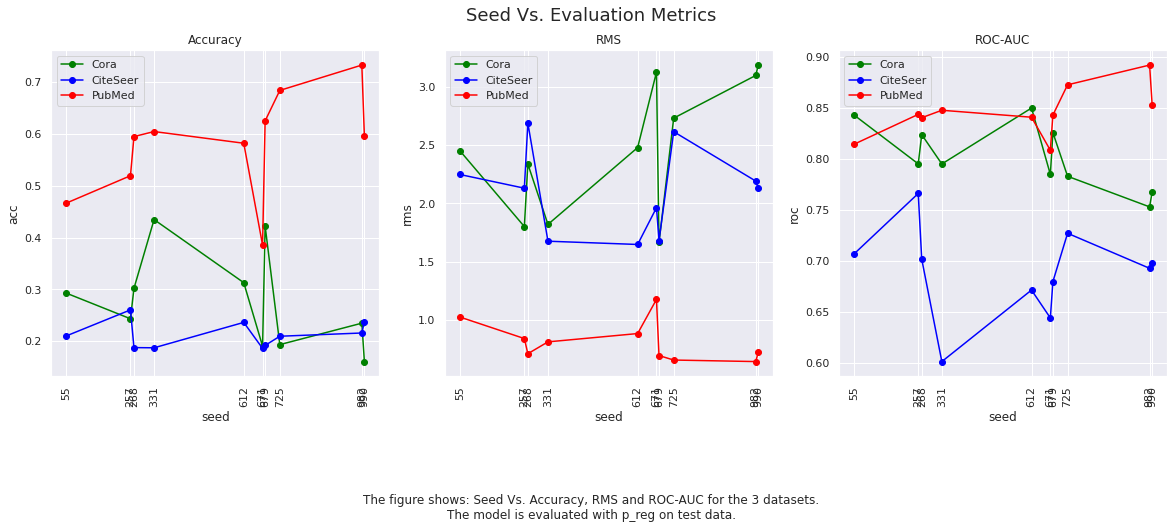

In [18]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [19]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best seed on test: 331
    rms best seed on test: 679
    roc best seed on test: 612
========= CiteSeer:
    acc best seed on test: 257
    rms best seed on test: 612
    roc best seed on test: 257
========= PubMed:
    acc best seed on test: 982
    rms best seed on test: 982
    roc best seed on test: 982


In [20]:
# ============================================ 
# L03 P02 Q03 (without P-reg)
# ===========================================
# set parameters
As = [50,75,100,125,150] 
Bs = 180-np.array(As)   # 180 is the max for sum A and B 

In [21]:
# train an evaluate
Results, params, params_tag, reg_loss = train_evaluation(As = As, Bs = Bs, reg_loss=None)

Training with different "Number Training Nodes" (with no_reg):
Cora:
0%: A,B= (50,130), Loss: 0.6917
    Val_acc : 0.6446, Val_rms : 1.5295, Val_roc : 0.9215
    Test_acc: 0.6218, Test_rms: 1.6015, Test_roc: 0.9182
40%: A,B= (100,80), Loss: 0.8372
    Val_acc : 0.6603, Val_rms : 1.4201, Val_roc : 0.9345
    Test_acc: 0.6488, Test_rms: 1.4767, Test_roc: 0.9248
80%: A,B= (150,30), Loss: 0.8603
    Val_acc : 0.6864, Val_rms : 1.3727, Val_roc : 0.9387
    Test_acc: 0.6653, Test_rms: 1.4227, Test_roc: 0.9332
CiteSeer:
0%: A,B= (50,130), Loss: 0.6611
    Val_acc : 0.5657, Val_rms : 1.2977, Val_roc : 0.8510
    Test_acc: 0.5332, Test_rms: 1.4285, Test_roc: 0.8574
40%: A,B= (100,80), Loss: 0.8390
    Val_acc : 0.5562, Val_rms : 1.2125, Val_roc : 0.8481
    Test_acc: 0.5494, Test_rms: 1.3440, Test_roc: 0.8608
80%: A,B= (150,30), Loss: 0.9209
    Val_acc : 0.5952, Val_rms : 1.1721, Val_roc : 0.8635
    Test_acc: 0.5767, Test_rms: 1.3218, Test_roc: 0.8800
PubMed:
0%: A,B= (50,130), Loss: 0.3988
 

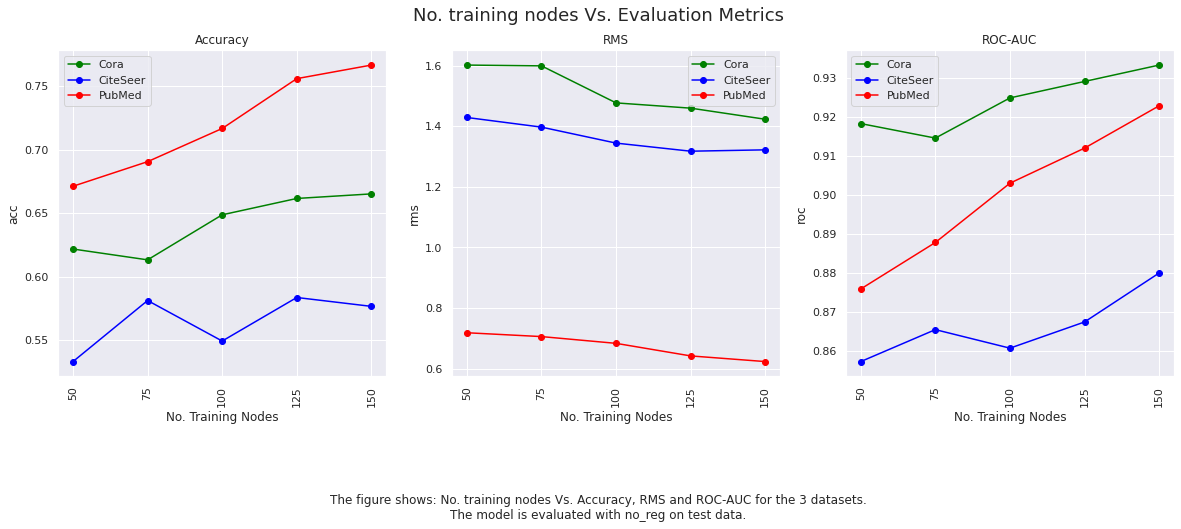

In [22]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [23]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best No. Training Nodes on test: 150
    rms best No. Training Nodes on test: 150
    roc best No. Training Nodes on test: 150
========= CiteSeer:
    acc best No. Training Nodes on test: 125
    rms best No. Training Nodes on test: 125
    roc best No. Training Nodes on test: 150
========= PubMed:
    acc best No. Training Nodes on test: 150
    rms best No. Training Nodes on test: 150
    roc best No. Training Nodes on test: 150


In [24]:
# ============================================ 
# L03 P02 Q03 (with P-reg)
# ===========================================
# set parameters
As = [50,75,100,125,150] 
Bs = 180-np.array(As)   # 180 is the max for sum A and B 
mu = 0.3

In [25]:
# train an evaluate
Results, params, params_tag, reg_loss = train_evaluation(As = As, Bs = Bs, mu=mu, reg_loss='p_reg')

Training with different "Number Training Nodes" (with p_reg):
Cora:
0%: A,B= (50,130), Loss: 1.1251
    Val_acc : 0.5529, Val_rms : 1.4555, Val_roc : 0.9036
    Test_acc: 0.5118, Test_rms: 1.5457, Test_roc: 0.9073
40%: A,B= (100,80), Loss: 1.2768
    Val_acc : 0.6229, Val_rms : 1.4040, Val_roc : 0.9232
    Test_acc: 0.5836, Test_rms: 1.4837, Test_roc: 0.9177
80%: A,B= (150,30), Loss: 1.3017
    Val_acc : 0.6446, Val_rms : 1.3729, Val_roc : 0.9309
    Test_acc: 0.6184, Test_rms: 1.4413, Test_roc: 0.9279
CiteSeer:
0%: A,B= (50,130), Loss: 1.0633
    Val_acc : 0.4200, Val_rms : 1.4502, Val_roc : 0.8190
    Test_acc: 0.3622, Test_rms: 1.5553, Test_roc: 0.8255
40%: A,B= (100,80), Loss: 1.2811
    Val_acc : 0.4922, Val_rms : 1.2687, Val_roc : 0.8400
    Test_acc: 0.4922, Test_rms: 1.3744, Test_roc: 0.8539
80%: A,B= (150,30), Loss: 1.3643
    Val_acc : 0.5514, Val_rms : 1.2041, Val_roc : 0.8610
    Test_acc: 0.5360, Test_rms: 1.3237, Test_roc: 0.8771
PubMed:
0%: A,B= (50,130), Loss: 0.6743
  

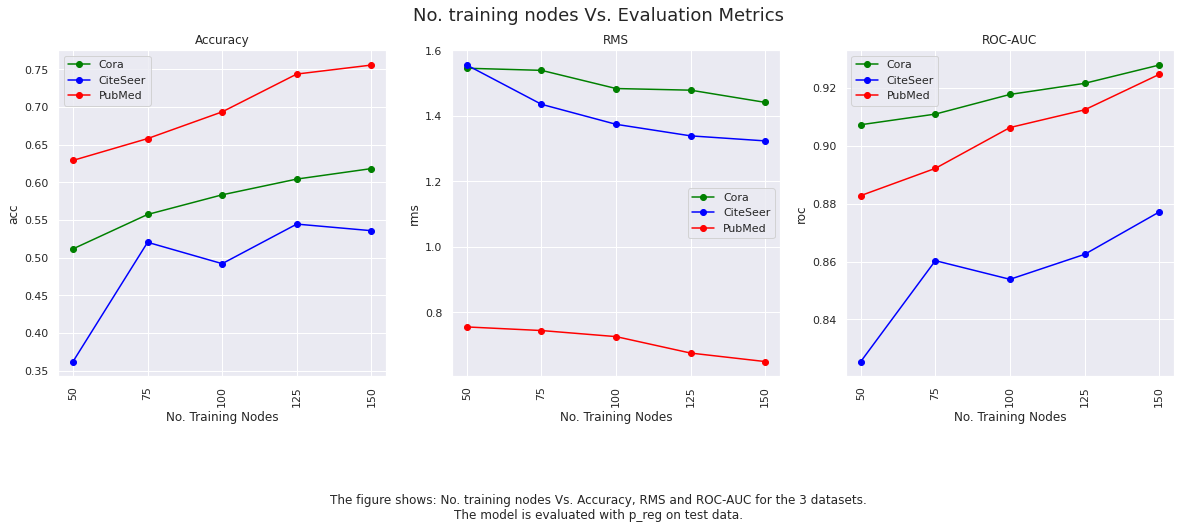

In [26]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [27]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best No. Training Nodes on test: 150
    rms best No. Training Nodes on test: 150
    roc best No. Training Nodes on test: 150
========= CiteSeer:
    acc best No. Training Nodes on test: 125
    rms best No. Training Nodes on test: 150
    roc best No. Training Nodes on test: 150
========= PubMed:
    acc best No. Training Nodes on test: 150
    rms best No. Training Nodes on test: 150
    roc best No. Training Nodes on test: 150


In [8]:
# ============================================ 
# L03 P02 Q01 with lap-reg
# ============================================
# set parameters
mus = np.linspace(0,1,20)

In [9]:
# train and evaluate 
Results, params, params_tag, reg_loss = train_evaluation(mus=mus, reg_loss='lap_reg')

Training with different "Mus" (with lap_reg):
Cora:
0%: mu= 0.0000, Loss: 0.8250
    Val_acc : 0.7575, Val_rms : 1.5691, Val_roc : 0.9382
    Test_acc: 0.7724, Test_rms: 1.4228, Test_roc: 0.9483
25%: mu= 0.2632, Loss: 1.2259
    Val_acc : 0.7132, Val_rms : 1.5654, Val_roc : 0.9326
    Test_acc: 0.7307, Test_rms: 1.4809, Test_roc: 0.9439
50%: mu= 0.5263, Loss: 1.3403
    Val_acc : 0.6884, Val_rms : 1.5711, Val_roc : 0.9286
    Test_acc: 0.7090, Test_rms: 1.5284, Test_roc: 0.9402
75%: mu= 0.7895, Loss: 1.4045
    Val_acc : 0.6742, Val_rms : 1.6036, Val_roc : 0.9267
    Test_acc: 0.6922, Test_rms: 1.5746, Test_roc: 0.9379
CiteSeer:
0%: mu= 0.0000, Loss: 0.8093
    Val_acc : 0.6801, Val_rms : 1.2254, Val_roc : 0.8928
    Test_acc: 0.6792, Test_rms: 1.4231, Test_roc: 0.8872
25%: mu= 0.2632, Loss: 1.0277
    Val_acc : 0.6753, Val_rms : 1.1913, Val_roc : 0.8841
    Test_acc: 0.6671, Test_rms: 1.3318, Test_roc: 0.8828
50%: mu= 0.5263, Loss: 1.1059
    Val_acc : 0.6580, Val_rms : 1.1929, Val_ro

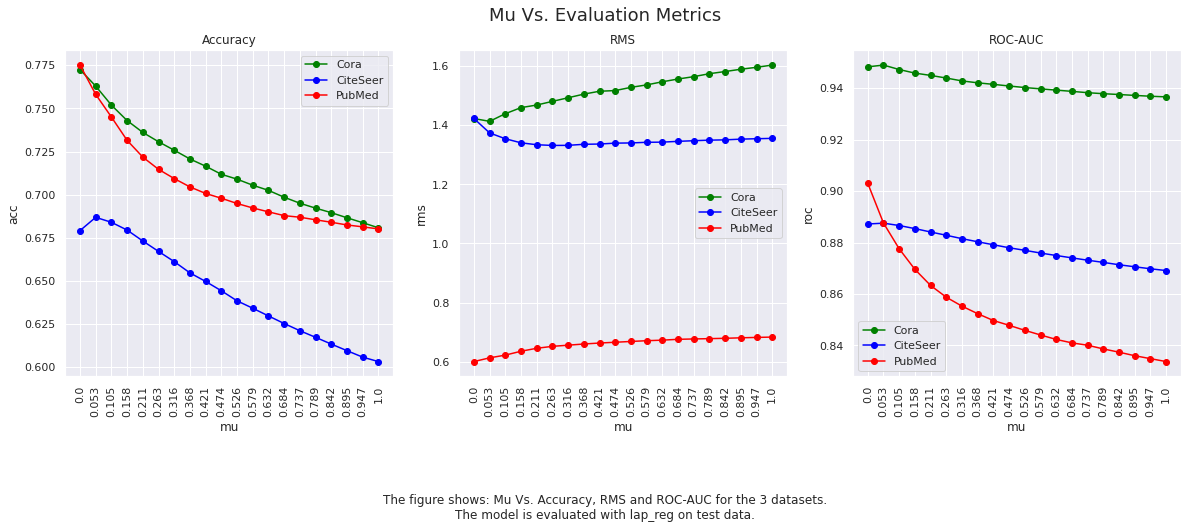

In [10]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [11]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best mu on test: 0.0
    rms best mu on test: 0.053
    roc best mu on test: 0.053
========= CiteSeer:
    acc best mu on test: 0.053
    rms best mu on test: 0.263
    roc best mu on test: 0.053
========= PubMed:
    acc best mu on test: 0.0
    rms best mu on test: 0.0
    roc best mu on test: 0.0
